In [104]:
import yaml
import numpy as np

with open("../models/EtOxModel/EtOxModel.yaml", "r") as f:
    cfg = yaml.safe_load(f)

p = cfg["equation_parameters"]


# gas density
T = 600
p0 = float(p["p0"])
rho_g = p["M_tot"] * p0 / (p["R_g"] * T)
mu_g = p["A_mu"] * T**2 + p["B_mu"] * T + p["F_mu"]
cp_g = p["cp_g"] / p["M_tot"]  # mass heat capacity of the gas phase
u_flow = 1
lam_g = p["lam_g"]
eps0 = p["eps_0"]
lam_p = (1 - p["eps_p"]) * p["lam_pm"]
d_t = p["d"]
d_p = p["dp"]



# rho_g = 1.045 # kg/m3
# cp_g = 1009 # J / kg K
# lam_g = 0.0286 # W / m K
# lam_p = 1.2 # W / m K
# u_flow = 0.542 # m / s
# d_p = 0.0064 # m
# d_t = 0.0754 # m
# eps0 = 0.4
# mu_g = 19.27e-6 * rho_g


k_p = lam_p / lam_g
B = 1.25 * ((1 - eps0) / eps0) ** (10 / 9)
N = 1 - B/k_p
k_c = 2 / N * (B/N**2 * (k_p-1)/k_p * np.log(k_p/B) - 0.5*(B+1) - (B-1)/N)
lam_c = k_c * lam_g
print("k_core: ", k_c)
print("lam_core: ", lam_c)

k_bed = 1 - np.sqrt(1-eps0) + np.sqrt(1-eps0)*k_c
lam_bed = k_bed * lam_g
print("k_bed: ", k_bed)
# gas viscosity

Re = lambda dp: dp * u_flow * rho_g / mu_g
Pr = mu_g * cp_g / lam_g
Nu_w = lambda dp: (
    0.19 * Re(dp) ** (3 / 4) * Pr ** (3 / 3)
    + lam_bed / lam_g * (1.3 + 5 * dp / d_t)
)
Nu_pipe = (49.371 + (1.615 * (Re(d_t) * Pr * d_t / p["L"])**(1/3) - 0.7)**3)**(1/3)
alph_w = lambda dp: Nu_w(dp) * lam_g / d_p
print("d_p: ", d_p, " d_tube: ", d_t, " m", " d_tube / d_p: ", d_t/d_p)
print("Nu_pipe: ", Nu_pipe)
print("Nu_w: ", Nu_w(d_p))
print("Pr: ", Pr)
print("Re: ", Re(d_p))

k_core:  11.399257177826698
lam_core:  0.5138899128336054
k_bed:  9.05522997253015
d_p:  0.004  d_tube:  0.08  m  d_tube / d_p:  20.0
Nu_pipe:  8.78532001320308
Nu_w:  46.542632434867485
Pr:  0.7905385354480919
Re:  1299.3738532258399


Text(0.5, 1.0, '$\\lambda_b$ / $\\lambda_g$=9.06     $d_t$ / $d_p$ = 20.0')

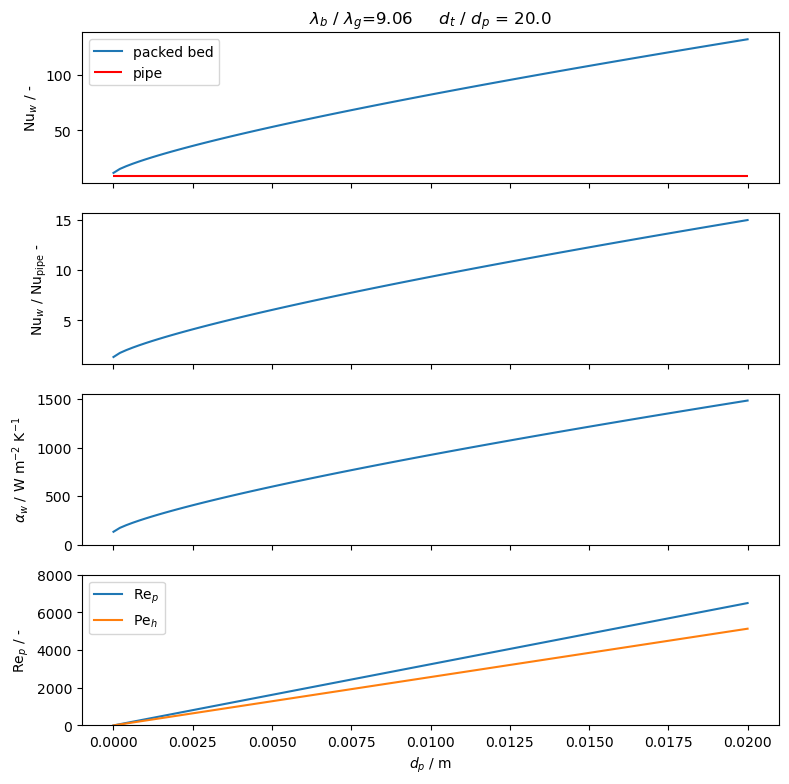

In [105]:
dp_vec = np.linspace(0, 0.02, 100)
Nu_w_vec = Nu_w(dp_vec)
Re_vec = Re(dp_vec)
Nu_ratio_vec = Nu_w_vec / Nu_pipe
alph_w_vec = alph_w(dp_vec)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(4, sharex=True, figsize=(9,9))
ax[0].plot(dp_vec, Nu_w_vec, label = "packed bed")
ax[0].hlines(Nu_pipe, dp_vec[0], dp_vec[-1], label = "pipe", color="red")
ax[0].legend()
ax[1].plot(dp_vec, Nu_ratio_vec)
ax[1].set_ylabel(r"Nu$_w$ / Nu$_\text{pipe}$ -")
ax[2].plot(dp_vec, alph_w_vec)
ax[2].set_ylim(0)
ax[-1].set_xlabel(r"$d_p$ / m")
ax[0].set_ylabel(r"Nu$_w$ / -")
ax[2].set_ylabel(r"$\alpha_w$ / W m$^{-2}$ K$^{-1}$")
ax[3].plot(dp_vec, Re_vec, label=r"Re$_p$")
ax[3].plot(dp_vec, Re_vec * Pr, label=r"Pe$_h$")
ax[3].legend()
ax[3].set_ylabel(r"Re$_p$ / -")
ax[3].set_ylim(0, 8000)


ax[0].set_title(fr"$\lambda_b$ / $\lambda_g$={round(k_bed, 2)}     $d_t$ / $d_p$ = {d_t/d_p}")
